<a href="https://colab.research.google.com/github/Babitha23/Cyberbullying-detection/blob/main/data_preprocessing_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Required Libraries

In [1]:
!pip install wordcloud
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
%matplotlib inline
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Extraction

In [3]:
#load data from csv file and concat
data1 = pd.read_csv("sessions_0plus_to_10_metadata.csv", index_col=0, encoding = "ISO-8859-1")
data2 = pd.read_csv("sessions_10plus_to_40_metadata.csv", index_col=0, encoding = "ISO-8859-1")
data3 = pd.read_csv("sessions_40plus_metadata.csv", index_col=0, encoding = "ISO-8859-1")
data = pd.concat([data1,data2,data3], axis=0)

In [4]:
#check shape of the dataframes
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data.shape)

(278, 214)
(1018, 214)
(922, 214)
(2218, 214)


# Data Pre-processing

In [5]:
#Drop unwanted columns
data = data.drop(['_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'question1:confidence', 'question2:confidence', 'cptn_time', 'img_url', 'id', 'owner_id', 'cyberaggression', 'cyberbullying'], axis=1)

#Replace empty comments  with null value
data = data.replace('empety', np.NaN)
data = data.replace('empty', np.NaN)

#Create new column with concat of all the comments excluding null values
data['comments'] = data.iloc[:, 2:197].fillna('').agg('.'.join, axis=1)

#Remove individual comments columns
data = data.drop(data.iloc[:, 2:197], axis=1)

#concat owner's post along with comments
data['sessiontext'] = data['owner_cmnt'] + '.' + data['comments']

#Dropping owner_cmnt and comments columns
data = data.drop(['owner_cmnt', 'comments'], axis=1)

data.head()

,question1,question2,likes,shared media,followed_by,follows,sessiontext
_unit_id,,,,,,,
702714440,noneAgg,noneBll,4313\r\r likes,1477,53913,268,gosh we love these five idiots so much __ for...
702714441,noneAgg,noneBll,2102\r\r likes,761,426533,379,Anyone see the Pepsi halftime show commercial ...
702714442,noneAgg,noneBll,108939\r\r likes,698,1974089,389,Today I ate cr_pes and bought a drawing of ch...
702714443,aggression,bullying,6441\r\r likes,1257,349594,656,New works in progress for an upcoming show at ...
702714444,noneAgg,noneBll,1153\r\r likes,2052,60772,388,"Due to overwhelming response, we have went ahe..."


In [16]:
data.iloc[0, :]['sessiontext']

'gosh we love these five idiots so much __\x8f for me, they have seriously turned my life around and I am so thankful for that x ~Zhanna__Ô".<font color="#0066CC">lynnseyerinalexandra</font>   Zaaaayn  (created_at:2013-09-24 18:16:05).<font color="#0066CC">niazki.lam</font>   larry <3  (created_at:2013-09-24 18:27:04)...........<font color="#0066CC">69with_harryx</font>   I just was looking at lary  (created_at:2013-09-24 18:33:07)...........<font color="#0066CC">69with_harryx</font>   Larry  (created_at:2013-09-24 18:33:10)...........<font color="#0066CC">supaaaabbyy</font>   Larry having their little moment there :)  (created_at:2013-09-24 18:33:44)...........<font color="#0066CC">cliffordslittlesecret</font>   are of you actually fans of one direction ? or larry ? hard to tell tbh  (created_at:2013-09-24 18:36:28)...........<font color="#0066CC">boobguyniall</font>   <font color="#0066CC">@crazycrazycrazy1d</font> lmao just because ur an elounor shipper doesn\'t mean you have to be 

# Define cleaning functions

In [29]:
def cleancomments(text):
    tt = re.sub('\(created.at:\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d\)', '', str(text)) #replacing comment time
    tt1 = re.sub('<font color\=\"\#0066CC\"\>.*?\<\/font>', '', str(tt)) # removing html tags with username
    tt2 = re.sub('@[^\s]+', '', str(tt1)) #removing user tag
    #Remove unicode strings like "\u002c" and "x96"
    tmp = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', tt2) 
    temp = re.sub(r'[^\x00-\x7f]',r'',tmp)
    #removing url
    temp1 = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',temp)
    temp2 = re.sub(r'#([^\s]+)', r'\1', temp1) # removing hashtags
    #removing emoticons
    temp3 = re.sub(':\)|;\)|:-\)|<3|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', 'emoji', temp2)
    temp4 = re.sub(' +', ' ', temp3) #removing additional whitespaces
    temp5 = re.sub(r"(\.)\1+", '.', temp4)
    temp6 = re.sub(r"( \.)+", '.', temp5)
    temp7 = re.sub(r"(\!)\1+", 'multiexclamation', temp6)
    temp8 = re.sub(r"(\_)+", '', temp7)
    temp9 = ' '.join( [w for w in temp8.split() if len(w)>1]) #removing single characters
    return temp9

def cleanlike(text):
    pattern = re.compile('[0-9]+')
    num = re.findall(pattern, text)
    return num[0]

def checkcomments():
    count = 0
    count1 = 0
    count2 = 0
    for i in range(2218):
        count = count + len(re.findall('\(created.at:\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d\)', str(data.iloc[i, :]['sessiontext'])))
        count1 = count1 + len(re.findall('<font color\=\"\#0066CC\"\>.*?\<\/font>', str(data.iloc[i, :]['sessiontext'])))
        count2 = count2 + len(re.findall('@[^\s]+', str(data.iloc[i, :]['sessiontext'])))
    print("time pattern appears", count, "times")
    print("html pattern appears", count1, "times")
    print("User tagging in owner's comment appear", count2, "times")

# def cleaning(text):
#     """ Removes unicode strings like "\u002c" and "x96" """
#     tmp = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
#     temp = re.sub(r'[^\x00-\x7f]',r'',tmp)
#     #removing url
#     temp1 = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',temp)
#     temp2 = re.sub(r'#([^\s]+)', r'\1', temp1) # removing hashtags
#     #removing emoticons
#     temp3 = re.sub(':\)|;\)|:-\)|<3|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', 'emoji', temp2)
#     temp4 = re.sub(' +', ' ', temp3) #removing additional whitespaces
#     temp5 = re.sub(r"(\.)\1+", '.', temp4)
#     temp6 = re.sub(r"( \.)+", '.', temp5)
#     temp6 = re.sub(r"(\!)\1+", 'multiexclamation', temp5)
#     temp7 = re.sub(r"(\_)+", '', temp6)
#     temp8 = ' '.join( [w for w in temp7.split() if len(w)>1]) #removing single characters
#     return temp8

In [32]:
print("Before cleaning:")
print("----------------")
checkcomments()

Before cleaning:
----------------
time pattern appears 156357 times
html pattern appears 235463 times
User tagging in owner's comment appear 70493 times


# Call the cleaning functions

In [33]:
#Removing html tags, usernames, comment time and cleaning 'likes' by calling the functions
for i in range(2218):
    data['sessiontext'] = data['sessiontext'].apply(lambda x: cleancomments(x))
    data['likes'] = data['likes'].apply(lambda y: cleanlike(y))
    
print("After cleaning:")
print("---------------")
checkcomments()

After cleaning:
---------------
time pattern appears 0 times
html pattern appears 0 times
User tagging in owner's comment appear 0 times


In [ ]:
# datacopy = data.copy(deep=True)

# for i in range(2218):
#     data['cleantext'] = data['sessiontext'].apply(lambda x: cleaning(x)) #introducing a new column for cleaned text

In [34]:
data.iloc[0, :]['sessiontext']

'gosh we love these five idiots so much for me, they have seriously turned my life around and am so thankful for that ~Zhanna". Zaaaayn. larry emoji. just was looking at lary. Larry. Larry having their little moment there emoji. are of you actually fans of one direction or larry hard to tell tbh. lmao just because ur an elounor shipper doesn\'t mean you have to be bitch lol shut up. not really. I\'m not bitch just saying that people only seem to care about larry nowadays. Larry. emoji. YALL matherfuckers Need Jesus. LOVE ME SOME 1D (ALL THE BOYS) the same. was staring at Niall the whole time lol. We got the Larry in this yay. Craic daddy craic daddy craic daddy. Ya same feel like they have changed so many peoples life\'s including mine emoji. Larry, zayn being too cool to dance, Liam being the big child he is, and then well. Niall being Niall Niall. Yesss. Omg it does hahahaha. se harry og louis, stt cemoji. LARRY ON THE SIDE IM SCREAMIG. Jaaaaaa Cemoji. LARRY Niall though. ily. Larry 

In [36]:
data.rename(columns={'question1' :'label1','question2': 'label2'},inplace=True)
df = data[['sessiontext', 'likes', 'shared media', 'followed_by', 'follows', 'label1', 'label2']]


# Exploratory data analysis

In [37]:
df.tail(5)

,sessiontext,likes,shared media,followed_by,follows,label1,label2
_unit_id,,,,,,,
652910872,Skills!. you don't want these problems!. Stick...,442,1607,24257,1322,aggression,noneBll
652910873,Lol. Die hard. Cause we represent The Donmulti...,196,2204,7457,741,noneAgg,noneBll
652910874,Who cares right? There both just books? can't ...,50,1905,1180,261,aggression,noneBll
652910875,Media posted at 014-06-21 20emoji57emoji44. do...,454,319,14265,485,aggression,noneBll
652910876,Next Stopemoji Knockout Round! defeated Croati...,37734,2009,888292,318,aggression,bullying


In [38]:
df.isnull().sum()

sessiontext     0
likes           0
shared media    0
followed_by     0
follows         0
label1          0
label2          0
dtype: int64

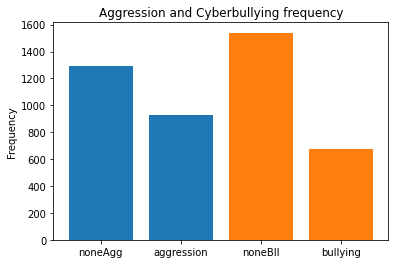

In [77]:
plt.bar(df.label1.value_counts().index, df.label1.value_counts())
plt.title("Aggression and Cyberbullying frequency")
plt.ylabel("Frequency")
plt.bar(df.label2.value_counts().index, df.label2.value_counts())
plt.show()

In [79]:
df.label1.value_counts()

noneAgg       1289
aggression     929
Name: label1, dtype: int64

In [80]:
df.label2.value_counts()

noneBll     1540
bullying     678
Name: label2, dtype: int64

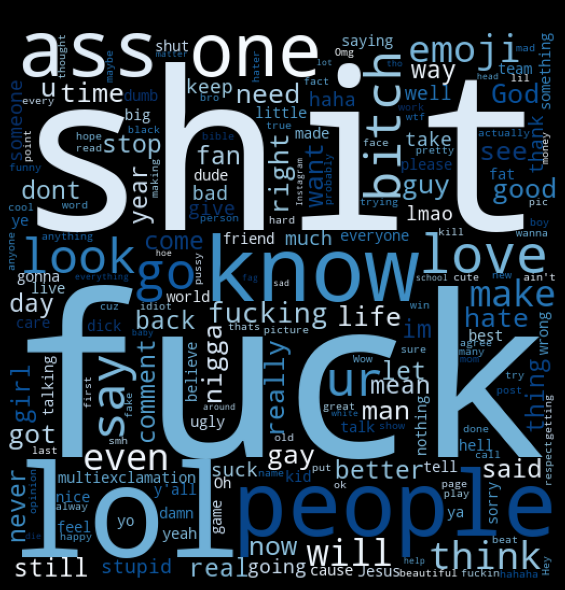

In [41]:
def wc(col, label, title):
  terms = ' '.join(list(df[df[col] == label]['sessiontext']))
  wcl = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(terms)
  plt.figure(figsize = (10, 8), facecolor = 'k')
  plt.imshow(wcl)
  plt.axis('off')
  plt.title(title, fontsize =25)
  plt.tight_layout(pad = 0)
  plt.show()

wc('label1', 'aggression', 'Aggression')

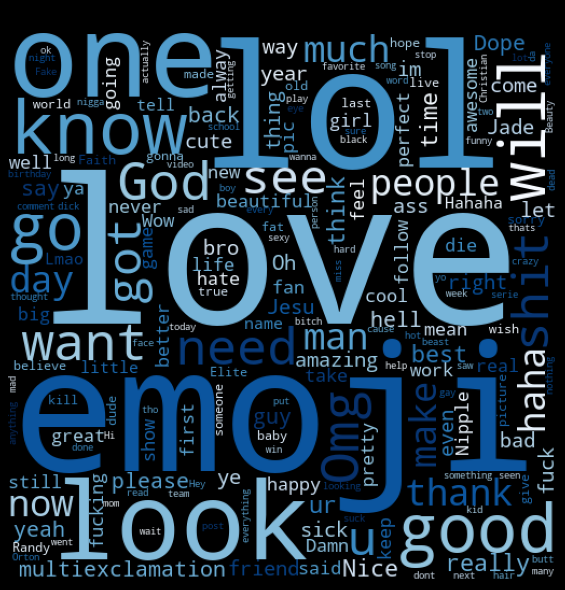

In [42]:
wc('label1', 'noneAgg', 'No Aggression')

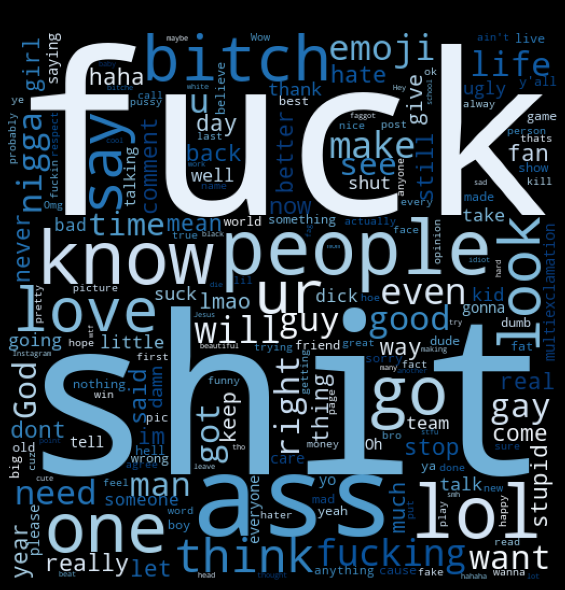

In [43]:
wc('label2', 'bullying', 'Bullying')

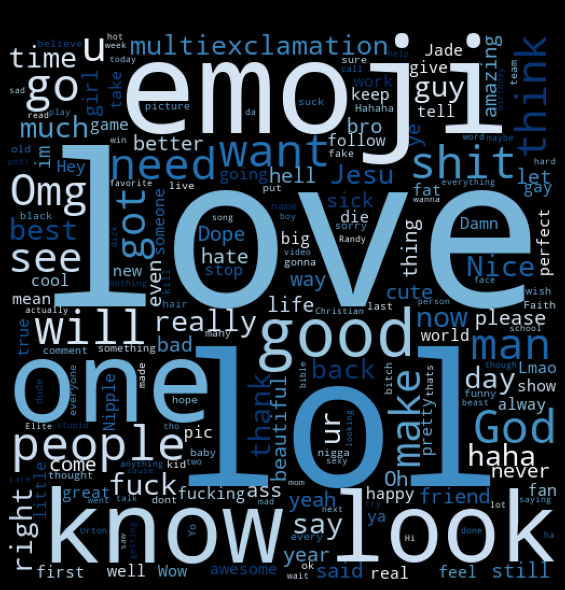

In [44]:
wc('label2', 'noneBll', 'Non-Bullying')